# In case, the file import data from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %cd /content/drive/MyDrive/Colab\ Notebooks/Thesis/
# %cd Mydrive/

%cd drive/MyDrive/Colab\ Notebooks
# !ls

/content/drive/MyDrive/Colab Notebooks


In [ ]:
# Install libraries
!pip install mne
!pip install pyriemann
!pip install MOABB
!pip install  scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Functions

In [ ]:
def scaling_eeg(inputs, max_af, min_af):
    """
    Scaling eeg with the relative value accord multiple channels
    Think about the amplitude between the maximum values of 
    eye blink at Fp1 and normal eeg signal at Oz

    max_af = maximum value in inputs after normalize
    min_af = minimum value in inputs after normalize
    max_bf = maximum value in inputs before normalize
    min_bf = minimum value in inputs before normalize
    """ 
    max_bf=np.max(inputs)
    min_bf=np.min(inputs) 
    scaled_inputs = ((max_af - min_af) * (inputs - min_bf) / (max_bf - min_bf)) + min_af
    return scaled_inputs

In [ ]:
def Regression_on_epochs(epochs):
    # do regression
    _, betas = mne.preprocessing.regress_artifact(epochs.copy().subtract_evoked())
    # Then use those coefficients to remove the EOG signal from the original data
    epochs_clean, _ = mne.preprocessing.regress_artifact(epochs, betas=betas)
    return epochs_clean

In [ ]:
def compute_kurtosis(data):
    
    """Kurtosis of the data (per channel).
    Parameters
    ----------
    data : ndarray, shape (n_channels, n_times)
    Returns
    -------
    output : ndarray, shape (n_channels,)
    Notes
    -----
    Alias of the feature function: **kurtosis**
    """
    
    ndim = data.ndim
    return scipy.stats.kurtosis(data, axis=ndim - 1, fisher=False)
def compute_kurtosis(data):
    
    """Kurtosis of the data (per channel).
    Parameters
    ----------
    data : ndarray, shape (n_channels, n_times)
    Returns
    -------
    output : ndarray, shape (n_channels,)
    Notes
    -----
    Alias of the feature function: **kurtosis**
    """
    
    ndim = data.ndim
    return scipy.stats.kurtosis(data, axis=ndim - 1, fisher=False)

def _app_samp_entropy_helper(data, emb, metric='chebyshev',
                             approximate=True):
    """Utility function for `compute_app_entropy`` and `compute_samp_entropy`.
    Parameters
    ----------
    data : ndarray, shape (n_channels, n_times)
    emb : int (default: 2)
        Embedding dimension.
    metric : str (default: chebyshev)
        Name of the metric function used with KDTree. The list of available
        metric functions is given by: ``KDTree.valid_metrics``.
    approximate : bool (default: True)
        If True, the returned values will be used to compute the
        Approximate Entropy (AppEn). Otherwise, the values are used to compute
        the Sample Entropy (SampEn).
    Returns
    -------
    output : ndarray, shape (n_channels, 2)
    """
    _all_metrics = KDTree.valid_metrics
    if metric not in _all_metrics:
        raise ValueError('The given metric (%s) is not valid. The valid '
                         'metric names are: %s' % (metric, _all_metrics))
    n_channels, n_times = data.shape
    phi = np.empty((n_channels, 2))
    for j in range(n_channels):
        r = 0.2 * np.std(data[j, :], axis=-1, ddof=1)
        # compute phi(emb, r)
        _emb_data1 = _embed(data[j, None], emb, 1)[0, :, :]
        if approximate:
            emb_data1 = _emb_data1
        else:
            emb_data1 = _emb_data1[:-1, :]
        count1 = KDTree(emb_data1, metric=metric).query_radius(
            emb_data1, r, count_only=True).astype(np.float64)
        # compute phi(emb + 1, r)
        emb_data2 = _embed(data[j, None], emb + 1, 1)[0, :, :]
        count2 = KDTree(emb_data2, metric=metric).query_radius(
            emb_data2, r, count_only=True).astype(np.float64)
        if approximate:
            phi[j, 0] = np.mean(np.log(count1 / emb_data1.shape[0]))
            phi[j, 1] = np.mean(np.log(count2 / emb_data2.shape[0]))
        else:
            phi[j, 0] = np.mean((count1 - 1) / (emb_data1.shape[0] - 1))
            phi[j, 1] = np.mean((count2 - 1) / (emb_data2.shape[0] - 1))
    return phi


def compute_app_entropy(data, emb=2, metric='chebyshev'):
    """Approximate Entropy (AppEn, per channel).
    Parameters
    ----------
    data : ndarray, shape (n_channels, n_times)
    emb : int (default: 2)
        Embedding dimension.
    metric : str (default: chebyshev)
        Name of the metric function used with
        :class:`~sklearn.neighbors.KDTree`. The list of available
        metric functions is given by: ``KDTree.valid_metrics``.
    Returns
    -------
    output : ndarray, shape (n_channels,)
    Notes
    -----
    Alias of the feature function: **app_entropy**. See [1]_.
    References
    ----------
    .. [1] Richman, J. S. et al. (2000). Physiological time-series analysis
           using approximate entropy and sample entropy. American Journal of
           Physiology-Heart and Circulatory Physiology, 278(6), H2039-H2049.
    """
    phi = _app_samp_entropy_helper(data, emb=emb, metric=metric,
                                   approximate=True)
    return np.subtract(phi[:, 0], phi[:, 1])


def compute_samp_entropy(data, emb=2, metric='chebyshev'):
    
    """Sample Entropy (SampEn, per channel).
    Parameters
    ----------
    data : ndarray, shape (n_channels, n_times)
    emb : int (default: 2)
        Embedding dimension.
    metric : str (default: chebyshev)
        Name of the metric function used with KDTree. The list of available
        metric functions is given by: `KDTree.valid_metrics`.
    Returns
    -------
    output : ndarray, shape (n_channels,)
    Notes
    -----
    Alias of the feature function: **samp_entropy**. See [1]_.
    References
    ----------
    .. [1] Richman, J. S. et al. (2000). Physiological time-series analysis
           using approximate entropy and sample entropy. American Journal of
           Physiology-Heart and Circulatory Physiology, 278(6), H2039-H2049.
    """
    phi = _app_samp_entropy_helper(data, emb=emb, metric=metric,
                                   approximate=False)
    if np.allclose(phi[:, 0], 0) or np.allclose(phi[:, 1], 0):
        raise ValueError('Sample Entropy is not defined.')
    else:
        return -np.log(np.divide(phi[:, 1], phi[:, 0]))
    
def _embed(x, d, tau):
    """Time-delay embedding.
    Parameters
    ----------
    x : ndarray, shape (n_channels, n_times)
    d : int
        Embedding dimension.
        The embedding dimension ``d`` should be greater than 2.
    tau : int
        Delay.
        The delay parameter ``tau`` should be less or equal than
        ``floor((n_times - 1) / (d - 1))``.
    Returns
    -------
    output : ndarray, shape (n_channels, n_times - (d - 1) * tau, d)
    """
    tau_max = np.floor((x.shape[1] - 1) / (d - 1))
    if tau > tau_max:
        warn('The given value (%s) for the parameter `tau` exceeds '
             '`tau_max = floor((n_times - 1) / (d - 1))`. Using `tau_max` '
             'instead.' % tau)
        _tau = tau_max
    else:
        _tau = int(tau)
    x = x.copy()
    X = np.lib.stride_tricks.as_strided(
        x, (x.shape[0], x.shape[1] - d * _tau + _tau, d),
        (x.strides[-2], x.strides[-1], x.strides[-1] * _tau))
    return X
def _app_samp_entropy_helper(data, emb, metric='chebyshev',
                             approximate=True):
    """Utility function for `compute_app_entropy`` and `compute_samp_entropy`.
    Parameters
    ----------
    data : ndarray, shape (n_channels, n_times)
    emb : int (default: 2)
        Embedding dimension.
    metric : str (default: chebyshev)
        Name of the metric function used with KDTree. The list of available
        metric functions is given by: ``KDTree.valid_metrics``.
    approximate : bool (default: True)
        If True, the returned values will be used to compute the
        Approximate Entropy (AppEn). Otherwise, the values are used to compute
        the Sample Entropy (SampEn).
    Returns
    -------
    output : ndarray, shape (n_channels, 2)
    """
    _all_metrics = KDTree.valid_metrics
    if metric not in _all_metrics:
        raise ValueError('The given metric (%s) is not valid. The valid '
                         'metric names are: %s' % (metric, _all_metrics))
    n_channels, n_times = data.shape
    phi = np.empty((n_channels, 2))
    for j in range(n_channels):
        r = 0.2 * np.std(data[j, :], axis=-1, ddof=1)
        # compute phi(emb, r)
        _emb_data1 = _embed(data[j, None], emb, 1)[0, :, :]
        if approximate:
            emb_data1 = _emb_data1
        else:
            emb_data1 = _emb_data1[:-1, :]
        count1 = KDTree(emb_data1, metric=metric).query_radius(
            emb_data1, r, count_only=True).astype(np.float64)
        # compute phi(emb + 1, r)
        emb_data2 = _embed(data[j, None], emb + 1, 1)[0, :, :]
        count2 = KDTree(emb_data2, metric=metric).query_radius(
            emb_data2, r, count_only=True).astype(np.float64)
        if approximate:
            phi[j, 0] = np.mean(np.log(count1 / emb_data1.shape[0]))
            phi[j, 1] = np.mean(np.log(count2 / emb_data2.shape[0]))
        else:
            phi[j, 0] = np.mean((count1 - 1) / (emb_data1.shape[0] - 1))
            phi[j, 1] = np.mean((count2 - 1) / (emb_data2.shape[0] - 1))
    return phi


def compute_app_entropy(data, emb=2, metric='chebyshev'):
    """Approximate Entropy (AppEn, per channel).
    Parameters
    ----------
    data : ndarray, shape (n_channels, n_times)
    emb : int (default: 2)
        Embedding dimension.
    metric : str (default: chebyshev)
        Name of the metric function used with
        :class:`~sklearn.neighbors.KDTree`. The list of available
        metric functions is given by: ``KDTree.valid_metrics``.
    Returns
    -------
    output : ndarray, shape (n_channels,)
    Notes
    -----
    Alias of the feature function: **app_entropy**. See [1]_.
    References
    ----------
    .. [1] Richman, J. S. et al. (2000). Physiological time-series analysis
           using approximate entropy and sample entropy. American Journal of
           Physiology-Heart and Circulatory Physiology, 278(6), H2039-H2049.
    """
    phi = _app_samp_entropy_helper(data, emb=emb, metric=metric,
                                   approximate=True)
    return np.subtract(phi[:, 0], phi[:, 1])


def compute_samp_entropy(data, emb=2, metric='chebyshev'):
    
    """Sample Entropy (SampEn, per channel).
    Parameters
    ----------
    data : ndarray, shape (n_channels, n_times)
    emb : int (default: 2)
        Embedding dimension.
    metric : str (default: chebyshev)
        Name of the metric function used with KDTree. The list of available
        metric functions is given by: `KDTree.valid_metrics`.
    Returns
    -------
    output : ndarray, shape (n_channels,)
    Notes
    -----
    Alias of the feature function: **samp_entropy**. See [1]_.
    References
    ----------
    .. [1] Richman, J. S. et al. (2000). Physiological time-series analysis
           using approximate entropy and sample entropy. American Journal of
           Physiology-Heart and Circulatory Physiology, 278(6), H2039-H2049.
    """
    phi = _app_samp_entropy_helper(data, emb=emb, metric=metric,
                                   approximate=False)
    if np.allclose(phi[:, 0], 0) or np.allclose(phi[:, 1], 0):
        raise ValueError('Sample Entropy is not defined.')
    else:
        return -np.log(np.divide(phi[:, 1], phi[:, 0]))
    
def _embed(x, d, tau):
    """Time-delay embedding.
    Parameters
    ----------
    x : ndarray, shape (n_channels, n_times)
    d : int
        Embedding dimension.
        The embedding dimension ``d`` should be greater than 2.
    tau : int
        Delay.
        The delay parameter ``tau`` should be less or equal than
        ``floor((n_times - 1) / (d - 1))``.
    Returns
    -------
    output : ndarray, shape (n_channels, n_times - (d - 1) * tau, d)
    """
    tau_max = np.floor((x.shape[1] - 1) / (d - 1))
    if tau > tau_max:
        warn('The given value (%s) for the parameter `tau` exceeds '
             '`tau_max = floor((n_times - 1) / (d - 1))`. Using `tau_max` '
             'instead.' % tau)
        _tau = tau_max
    else:
        _tau = int(tau)
    x = x.copy()
    X = np.lib.stride_tricks.as_strided(
        x, (x.shape[0], x.shape[1] - d * _tau + _tau, d),
        (x.strides[-2], x.strides[-1], x.strides[-1] * _tau))
    return X

In [ ]:
# Method for finding threshold, 'Thresholding selection rule'
def sqtwolog_threshold(wavelet_coeffs):
    """
    Universal thresholding
    """
    denom = scipy.stats.norm.ppf(0.75) # the constant value for Gaussian noise (0.6745)
    var = np.median(np.abs(wavelet_coeffs)) / denom
    N = len(wavelet_coeffs)
    thre = np.sqrt(var) * np.sqrt(2 * np.log(N))
    return thre

def rigsure_threshold(wavelet_coeffs):
    var = np.std(wavelet_coeffs)
    N = len(wavelet_coeffs)
    sqr_coeffs = []
    for coeff in wavelet_coeffs:
        sqr_coeffs.append(np.power(coeff, 2))
    sqr_coeffs.sort()
    pos = 0
    r = 0
    for idx, sqr_coeff in enumerate(sqr_coeffs):
        new_r = (N - 2 * (idx + 1) + (N - (idx + 1))*sqr_coeff + sum(sqr_coeffs[0:idx+1])) / N
        if r == 0 or r > new_r:
            r = new_r
            pos = idx
    thre = np.sqrt(var) * np.sqrt(sqr_coeffs[pos])
    return thre

def heursure_threshold(wavelet_coeffs):
    N = len(wavelet_coeffs)
    s = 0
    for coeff in wavelet_coeffs:
        s += np.power(coeff, 2)
    theta = (s - N) / N
    # It is divide by ...
    miu = np.power(np.log2(N), 3/2) / np.power(N, 1/2)
    if theta < miu:
        return sqtwolog_threshold(wavelet_coeffs)
    else:
        return min(sqtwolog_threshold(wavelet_coeffs), rigsure_threshold(wavelet_coeffs))
    
def statistical_threshold(wavelet_coeffs):
    """
    Put wavelet coefficients of one level to the function
    Return the statistical threshold value of that level
    """
    threshold_value = 1.5 * np.std(wavelet_coeffs)
    return threshold_value

In [ ]:
def denoised_with_DiscreteWavelet(oneCH_EEG, 
                                  motherWavelet="bior3.9", decLevel=8, 
                                  thresholdSelectionRule="statistical_threshold", thresholdingFunction="hard",
                                  lcoeffLevel=1, rcoeffLevel=5):
    """
    contEEG is a dataset containing contaminated EEG (54 subjects each has 19 EEG channels)
    motherWavelet = 'bior3.9' (Paper)
    decLevel = 8 (Calculate)
    thresholdSelectionRule = "heursure_threshold" or "statistical_threshold"
    thresholdingFunction = "soft" or "hard" thresholding
    lcoeffLevel = the coefficients corresponding to lower frequency bands that we want to threshold/denoise
    rcoeffLevel = the coefficients corresponding to upper frequency bands that we want to threshold/denoise
    """
    
    denoised_coeffs = [] # Prepare for contain denoise coefficients
    coeffs = pywt.wavedec(oneCH_EEG, wavelet=motherWavelet, level=decLevel)
    for ix, coeff in enumerate(coeffs):
        # thresholding has been done over the cD from level 8 up to level 3 (Cover OAs freq. band/related coefficients)
        threshold_value = None
        if ix in range(lcoeffLevel,rcoeffLevel):
            if thresholdSelectionRule == "statistical_threshold":
                threshold_value = statistical_threshold(wavelet_coeffs=coeff)
            else:
                threshold_value = heursure_threshold(wavelet_coeffs=coeff)

            # According to the paper
            # wavelet coefficient (wc) is removed if np.abs(wc) > threshold value
            denoised_coeff = np.where(np.abs(coeff) > threshold_value, 0, coeff)
            denoised_coeffs.append(denoised_coeff)

        else:
            denoised_coeffs.append(coeff)  
        
    denoised_oneCH_EEG = pywt.waverec(denoised_coeffs, wavelet=motherWavelet)
    return denoised_oneCH_EEG

In [ ]:
def signals_to_sources(ica, data):
    """Compute sources from data (operates inplace)."""
    _data = data.copy()
    _data = ica._pre_whiten(_data)
    if ica.pca_mean_ is not None:
        _data -= ica.pca_mean_[:, None]

    # Apply unmixing
    pca_data = np.dot(ica.unmixing_matrix_,
                    ica.pca_components_[:ica.n_components_,:])
    # Apply PCA
    sources = np.dot(pca_data, _data)
    return sources

def sources_to_signals(ica, sources):
    """Compute Mixed signals from sources (operates inplace)."""
    _sources = sources.copy()
    # Apply mixing (Inverse of product)
    inv_pca_data = np.dot(np.linalg.inv(ica.pca_components_)[:,:ica.n_components_],ica.mixing_matrix_)
    # Apply invsersed PCA
    _data = np.dot(inv_pca_data, _sources)

    if ica.pca_mean_ is not None:
        _data += ica.pca_mean_[:, None]
    _data *= ica.pre_whitener_
    return _data

In [ ]:
def wICA_on_raw_N170(raw, EOG_ref=False, ECG_ref=False):  
    """
    If EOG_ref == True:
        Detecting EOG artifact IC(s) depend on EOG reference channels
    If EOG_ref == True:
        Detecting EOG artifact IC(s) depend on EOG reference channels
    Else:
        Detecting artifact IC(s) by mMSE and Kurtosis
    """
    filt_raw = raw.copy()

    n_eeg = filt_raw.get_channel_types().count('eeg')
    n_eog = filt_raw.get_channel_types().count('eog')
    n_ecg = filt_raw.get_channel_types().count('ecg')

    ica = ICA(n_components=n_eeg, method="infomax", 
            fit_params=dict(extended=True), random_state=32)
    ica.fit(filt_raw)
  
    # Get ICs
    cont_epochs_sources = ica.get_sources(filt_raw).get_data()
    cont_IC_samples = cont_epochs_sources.shape[-1]
    # Use EOG reference channels to find which IC is EOG pattern
    if EOG_ref == True:
        eog_indices, eog_scores = ica.find_bads_eog(filt_raw, verbose=False)
        artifact_ICs_indexs = np.zeros((n_eeg), dtype=bool)
        artifact_ICs_indexs[eog_indices] = True

    else:
        # Calculate mMSE
        coarse_graining_ICs = []
        for e_IC in cont_epochs_sources:
            
            coarse_graining_e_IC = []
            length_data = e_IC.shape[-1]
            mMSE_scale_factor = 20
            range_coarse_graining = np.arange(1, int(length_data/mMSE_scale_factor)+1, 1)

            for j in range_coarse_graining:
                # Python is zero-index
                start_point = ((j-1)*mMSE_scale_factor)
                end_point = j * mMSE_scale_factor
                coase_graining = (1/mMSE_scale_factor) * np.sum(e_IC[start_point:end_point])
                coarse_graining_e_IC.append(coase_graining)
                
            coarse_graining_ICs.append(np.array(coarse_graining_e_IC))

        mMSE_ICs = compute_samp_entropy(data=np.array(coarse_graining_ICs))

        # Calculate Kurtosis
        kurtosis_ICs= []

        for e_IC in cont_epochs_sources:
            kurtosis_e_IC = compute_kurtosis(data=e_IC)
            kurtosis_ICs.append(kurtosis_e_IC)

        kurtosis_ICs = np.array(kurtosis_ICs)

        # Check which ICs are artifactual ICs
        # alpha level of two tailed t-test = 0.05
        alpha = 0.05
        critical_value = scipy.stats.t.ppf(q=1-alpha/2,df=int(n_eeg)-1)

        # Calculate Upper limit and Lower limit
        lower_limit= np.mean(mMSE_ICs) - ((np.std(mMSE_ICs) / np.sqrt(len(mMSE_ICs)) * critical_value))
        upper_limit= np.mean(kurtosis_ICs) - ((np.std(kurtosis_ICs) / np.sqrt(len(kurtosis_ICs))) * critical_value)

        # print(f"Check which IC is artifact IC\n {(mMSE_ICs < lower_limit) & (kurtosis_ICs > upper_limit)}")
        artifact_ICs_indexs = (mMSE_ICs < lower_limit) & (kurtosis_ICs > upper_limit)
        non_artifact_ICs_indexs = np.invert(artifact_ICs_indexs)

        artifact_ICs = cont_epochs_sources[artifact_ICs_indexs, :]
        non_artifact_ICs = cont_epochs_sources[non_artifact_ICs_indexs, :]


    # Denoise artifactual ICs with Wavelet
    denoised_ICs = []
    for idx_IC, IC_bool in zip(range(n_eeg), artifact_ICs_indexs):
        
        selected_IC = cont_epochs_sources[idx_IC, :]
        
        # True if IC is artifactual IC
        if IC_bool == True:
            
            denoised_IC = denoised_with_DiscreteWavelet(selected_IC, 
                                            motherWavelet="bior3.9", decLevel=8, 
                                            thresholdSelectionRule="statistical_threshold", 
                                            thresholdingFunction="hard",
                                            lcoeffLevel=1, rcoeffLevel=5)
            denoised_ICs.append(denoised_IC[:cont_IC_samples])
        # False if IC is non-artifactual IC
        elif IC_bool == False:
            denoised_ICs.append(selected_IC[:cont_IC_samples])

    # List to Numpy
    denoised_ICs = np.array(denoised_ICs)

    # Use ECG reference channels to find which IC is ECG pattern
    if ECG_ref == True: 
        ecg_indices, ecg_scores = ica.find_bads_ecg(filt_raw, method='correlation',
                                                    threshold='auto', verbose=False)
        # For checking IC(s) is not EOG IC
        eog_indices, eog_scores = ica.find_bads_eog(filt_raw, verbose=False)

        for ecg_index in ecg_indices:
            if ecg_index not in eog_indices:
                # Zero out
                denoised_ICs[ecg_index,:] = 0

    # Report artifactual ICs
    if EOG_ref == True and ECG_ref == True:
        # wICA with EOG reference and ICA with ECG reference
        eog_indices = eog_indices
        ecg_indices = ecg_indices
        print(f'artifact ICs are {np.union1d(eog_indices, ecg_indices)}')

    elif EOG_ref == True and ECG_ref == False:
        # wICA with EOG referece
        eog_indices = eog_indices
        ecg_indices = np.array([])
        print(f'artifact ICs are {np.union1d(eog_indices, ecg_indices)}')

    elif EOG_ref == False and ECG_ref == True:
        # wICA without EOG reference and ICA with ECG reference
        eog_indices = np.argwhere(artifact_ICs_indexs == True)
        ecg_indices = ecg_indices
        print(f'artifact ICs are {np.union1d(eog_indices, ecg_indices)}')
        
    else: # EOG_ref == False and ECG_ref == False:
        eog_indices = np.argwhere(artifact_ICs_indexs == True)
        ecg_indices = np.array([])
        print(f'artifact ICs are {np.union1d(eog_indices, ecg_indices)}')

    # Plot ICs
    ica.plot_components(list(np.union1d(eog_indices, ecg_indices).astype(int)))

    # Mix ICs to obtain mixed signals
    denoised_EEG = sources_to_signals(ica=ica, sources=denoised_ICs)
    # HEOG,VEOG,ECG
    non_eeg = raw._data[-3:]
    # Concatenate denoised EEG and non-eeg
    denoised_EEG = np.concatenate((denoised_EEG, non_eeg))
    # Create raw object for denoised EEG
    denoised_raw = raw.copy()
    denoised_raw._data = denoised_EEG

    return denoised_raw

In [ ]:
def sources_to_signals_3d(ica, Epochs_sources):
    np_data_3d = []
    for e_epoch in Epochs_sources:
        _sources = e_epoch.copy()
        # Apply mixing (Inverse of product)
        inv_pca_data = np.dot(np.linalg.inv(ica.pca_components_)[:,:ica.n_components_],ica.mixing_matrix_)
        # Apply invsersed PCA
        _data = np.dot(inv_pca_data, _sources)

        if ica.pca_mean_ is not None:
            _data += ica.pca_mean_[:, None]
        _data *= ica.pre_whitener_
        np_data_3d.append(_data)
    return np.array(np_data_3d)

In [ ]:
def wICA_on_Epochs(epochs, EOG_ref=False, ECG_ref=False):

    filt_epochs = epochs.copy()

    n_eeg = filt_epochs.get_channel_types().count('eeg')
    n_eog = filt_epochs.get_channel_types().count('eog')
    n_ecg = filt_epochs.get_channel_types().count('ecg')

    ica = ICA(n_components=n_eeg, method="infomax", 
            fit_params=dict(extended=True), random_state=32)
    ica.fit(filt_epochs)



    # Get ICs
    cont_epochs_sources = ica.get_sources(filt_epochs).get_data()
    cont_IC_samples = cont_epochs_sources.shape[-1]
    # Use EOG reference channels to find which IC is EOG pattern
    if EOG_ref == True:
        eog_indices, eog_scores = ica.find_bads_eog(filt_epochs, verbose=False)
        artifact_ICs_indexs = np.zeros((n_eeg), dtype=bool)
        artifact_ICs_indexs[eog_indices] = True

    else:
        # Calculate mMSE
        coarse_graining_ICs = []
        for e_IC in cont_epochs_sources:
            
            coarse_graining_e_IC = []
            length_data = e_IC.shape[-1]
            mMSE_scale_factor = 20
            range_coarse_graining = np.arange(1, int(length_data/mMSE_scale_factor)+1, 1)

            for j in range_coarse_graining:
                # Python is zero-index
                start_point = ((j-1)*mMSE_scale_factor)
                end_point = j * mMSE_scale_factor
                coase_graining = (1/mMSE_scale_factor) * np.sum(e_IC[start_point:end_point])
                coarse_graining_e_IC.append(coase_graining)
                
            coarse_graining_ICs.append(np.array(coarse_graining_e_IC))

        mMSE_ICs = compute_samp_entropy(data=np.array(coarse_graining_ICs))

        # Calculate Kurtosis
        kurtosis_ICs= []

        for e_IC in cont_epochs_sources:
            kurtosis_e_IC = compute_kurtosis(data=e_IC)
            kurtosis_ICs.append(kurtosis_e_IC)

        kurtosis_ICs = np.array(kurtosis_ICs)

        # Check which ICs are artifactual ICs
        # alpha level of two tailed t-test = 0.05
        alpha = 0.05
        critical_value = scipy.stats.t.ppf(q=1-alpha/2,df=int(n_eeg)-1)

        # Calculate Upper limit and Lower limit
        lower_limit= np.mean(mMSE_ICs) - ((np.std(mMSE_ICs) / np.sqrt(len(mMSE_ICs)) * critical_value))
        upper_limit= np.mean(kurtosis_ICs) - ((np.std(kurtosis_ICs) / np.sqrt(len(kurtosis_ICs))) * critical_value)

        # print(f"Check which IC is artifact IC\n {(mMSE_ICs < lower_limit) & (kurtosis_ICs > upper_limit)}")
        artifact_ICs_indexs = (mMSE_ICs < lower_limit) & (kurtosis_ICs > upper_limit)
        non_artifact_ICs_indexs = np.invert(artifact_ICs_indexs)

        artifact_ICs = cont_epochs_sources[artifact_ICs_indexs, :]
        non_artifact_ICs = cont_epochs_sources[non_artifact_ICs_indexs, :]
        
    # Denoise artifactual ICs with Wavelet
    denoised_epochs_sources = []
    for e_epoch in cont_epochs_sources:
        denoised_IC_chs = []
        for idx_IC, IC_bool in zip(range(n_eeg), artifact_ICs_indexs):
            e_IC = e_epoch[idx_IC, :]
            # True if IC is artifactual IC
            if IC_bool == True:
                
                denoised_e_IC = denoised_with_DiscreteWavelet(e_IC, 
                                                motherWavelet="bior3.9", decLevel=8, 
                                                thresholdSelectionRule="statistical_threshold", 
                                                thresholdingFunction="hard",
                                                lcoeffLevel=1, rcoeffLevel=5)
                denoised_IC_chs.append(denoised_e_IC[:cont_IC_samples])
            # False if IC is non-artifactual IC
            elif IC_bool == False:
                denoised_IC_chs.append(e_IC[:cont_IC_samples])
        denoised_epochs_sources.append(denoised_IC_chs)
    # List to Numpy
    denoised_epochs_sources = np.array(denoised_epochs_sources)

    # Use ECG reference channels to find which IC is ECG pattern
    if ECG_ref == True: 
        ecg_indices, ecg_scores = ica.find_bads_ecg(filt_epochs, method='correlation',
                                                    threshold='auto', verbose=False)
        # For checking IC(s) is not EOG IC
        eog_indices, eog_scores = ica.find_bads_eog(filt_epochs, verbose=False)

        for ecg_index in ecg_indices:
            if ecg_index not in eog_indices:
                # Zero out
                denoised_ICs[ecg_index,:] = 0
                
    # Report artifactual ICs
    if EOG_ref == True and ECG_ref == True:
        # wICA with EOG reference and ICA with ECG reference
        eog_indices = eog_indices
        ecg_indices = ecg_indices
        print(f'artifact ICs are {np.union1d(eog_indices, ecg_indices)}')

    elif EOG_ref == True and ECG_ref == False:
        # wICA with EOG referece
        eog_indices = eog_indices
        ecg_indices = np.array([])
        print(f'artifact ICs are {np.union1d(eog_indices, ecg_indices)}')

    elif EOG_ref == False and ECG_ref == True:
        # wICA without EOG reference and ICA with ECG reference
        eog_indices = np.argwhere(artifact_ICs_indexs == True)
        ecg_indices = ecg_indices
        print(f'artifact ICs are {np.union1d(eog_indices, ecg_indices)}')
        
    else: # EOG_ref == False and ECG_ref == False:
        eog_indices = np.argwhere(artifact_ICs_indexs == True)
        ecg_indices = np.array([])
        print(f'artifact ICs are {np.union1d(eog_indices, ecg_indices)}')
        
    ica.plot_components(list(np.union1d(eog_indices, ecg_indices).astype(int)))

    # Mix ICs to obtain mixed signals
    denoised_EEG = sources_to_signals_3d(ica, Epochs_sources=denoised_epochs_sources)
    # HEOG,VEOG,ECG
    non_eeg = epochs._data[:, -3:]
    # Concatenate denoised EEG and non-eeg
    denoised_EEG = np.concatenate((denoised_EEG, non_eeg), axis=1)
    # Create epochs object for denoised EEG
    denoised_epochs = epochs.copy()
    denoised_epochs._data = denoised_EEG
    return denoised_epochs

In [ ]:
def artifact_removal(raw, EOG_ref, ECG_ref):
    """
    Calling a function of artifact removal technique according to 
    EOG_ref and ECG_ref parameters

    EOG_ref has 4 options
    1) None
    2) 'wICA_without_ref'
    3) 'wICA_with_ref'
    4) 'SRGAN'

    ECG_ref has 3 options
    1) None
    2) ICA_with_ref
    3) wICA_with_ref
    """
    input_raw = raw.copy()
    sfreq_after_epoch = 200 # Resample or not

    if EOG_ref == None and ECG_ref == None:
        output_raw = input_raw

    elif EOG_ref == 'wICA_without_ref' and ECG_ref == None:
        output_raw = wICA_on_raw_N170(raw, EOG_ref=False, ECG_ref=False)

    elif EOG_ref == 'wICA_with_ref' and ECG_ref == None:
        output_raw = wICA_on_raw_N170(raw, EOG_ref=True, ECG_ref=False)

    elif EOG_ref == None and ECG_ref == 'ICA_with_ref':
        output_raw = ICA_on_raw_N170(raw, ECG_ref=True)

    elif EOG_ref == 'wICA_without_ref' and ECG_ref == 'ICA_with_ref':
        output_raw = wICA_on_raw_N170(raw, EOG_ref=False, ECG_ref=False)

    elif EOG_ref == 'wICA_with_ref' and ECG_ref == 'ICA_with_ref':
        output_raw = wICA_on_raw_N170(raw, EOG_ref=True, ECG_ref=False)

    elif EOG_ref == 'wICA_without_ref' and ECG_ref == 'wICA_with_ref':
        output_raw = wICA_on_raw_N170(raw, EOG_ref=False, ECG_ref=False)

    elif EOG_ref == 'wICA_with_ref' and ECG_ref == 'wICA_with_ref':
        output_raw = wICA_on_raw_N170(raw, EOG_ref=True, ECG_ref=False)

    elif EOG_ref == 'Regression' and ECG_ref == None:
        output_raw = Regression_on_epochs(raw)

    return output_raw

# Import libraries and read files

In [ ]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import seaborn as sns
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

import moabb
from moabb.datasets import BNCI2014004, Shin2017A
from moabb.evaluations import WithinSessionEvaluation, CrossSubjectEvaluation
from moabb.paradigms import LeftRightImagery


moabb.set_log_level("info")
mne.set_log_level("CRITICAL")
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import mne
from mne import find_events, Epochs, pick_types, read_evokeds
from mne.preprocessing import ICA

import pywt
import scipy
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
from sklearn.neighbors import KDTree

import seaborn as sns

import os
import re

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

## Extract contaminated eeg

In [ ]:
list_subjects = list(np.arange(1,21))
selected_dataset = Shin2017A(accept=True)
event_id = selected_dataset.event_id
print(event_id)
dataset = selected_dataset.get_data(subjects=list_subjects)
print(dataset)

{'left_hand': 1, 'right_hand': 2}
{1: {'session_0': {'run_0': <RawArray | 33 x 120436 (602.2 s), ~30.4 MB, data loaded>}, 'session_2': {'run_0': <RawArray | 33 x 119236 (596.2 s), ~30.1 MB, data loaded>}, 'session_4': {'run_0': <RawArray | 33 x 120851 (604.2 s), ~30.5 MB, data loaded>}}, 2: {'session_0': {'run_0': <RawArray | 33 x 120040 (600.2 s), ~30.3 MB, data loaded>}, 'session_2': {'run_0': <RawArray | 33 x 120624 (603.1 s), ~30.4 MB, data loaded>}, 'session_4': {'run_0': <RawArray | 33 x 120054 (600.3 s), ~30.3 MB, data loaded>}}, 3: {'session_0': {'run_0': <RawArray | 33 x 119446 (597.2 s), ~30.1 MB, data loaded>}, 'session_2': {'run_0': <RawArray | 33 x 120466 (602.3 s), ~30.4 MB, data loaded>}, 'session_4': {'run_0': <RawArray | 33 x 120244 (601.2 s), ~30.3 MB, data loaded>}}, 4: {'session_0': {'run_0': <RawArray | 33 x 119071 (595.4 s), ~30.0 MB, data loaded>}, 'session_2': {'run_0': <RawArray | 33 x 120465 (602.3 s), ~30.4 MB, data loaded>}, 'session_4': {'run_0': <RawArray 

In [ ]:
print(selected_dataset.paradigm)
print(dataset)
print(dataset[1])

imagery
{1: {'session_0': {'run_0': <RawArray | 33 x 120436 (602.2 s), ~30.4 MB, data loaded>}, 'session_2': {'run_0': <RawArray | 33 x 119236 (596.2 s), ~30.1 MB, data loaded>}, 'session_4': {'run_0': <RawArray | 33 x 120851 (604.2 s), ~30.5 MB, data loaded>}}, 2: {'session_0': {'run_0': <RawArray | 33 x 120040 (600.2 s), ~30.3 MB, data loaded>}, 'session_2': {'run_0': <RawArray | 33 x 120624 (603.1 s), ~30.4 MB, data loaded>}, 'session_4': {'run_0': <RawArray | 33 x 120054 (600.3 s), ~30.3 MB, data loaded>}}, 3: {'session_0': {'run_0': <RawArray | 33 x 119446 (597.2 s), ~30.1 MB, data loaded>}, 'session_2': {'run_0': <RawArray | 33 x 120466 (602.3 s), ~30.4 MB, data loaded>}, 'session_4': {'run_0': <RawArray | 33 x 120244 (601.2 s), ~30.3 MB, data loaded>}}, 4: {'session_0': {'run_0': <RawArray | 33 x 119071 (595.4 s), ~30.0 MB, data loaded>}, 'session_2': {'run_0': <RawArray | 33 x 120465 (602.3 s), ~30.4 MB, data loaded>}, 'session_4': {'run_0': <RawArray | 33 x 119672 (598.4 s), ~

In [ ]:
test_raw = dataset[1]['session_0']['run_0'].copy()
print(test_raw.ch_names)
# events = mne.find_events(dataset[1]['session_0']['run_0'], stim_channel='stim')
events = mne.find_events(dataset[1]['session_0']['run_0'], stim_channel='Stim')
print(events.shape)

['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']
(20, 3)


In [ ]:
# Shin2017A
sfreq_after_epoch = int(test_raw.info['sfreq'])
n_event_ids = 20 # The least #epochs per run
selected_eeg_chs = test_raw.copy().pick_types(eeg=True, 
                                       eog=False, 
                                       ecg=False,
                                       stim=False).ch_names
# #samples in imagery period
time_per_task = 10
selected_data_len =  int(time_per_task * sfreq_after_epoch)

In [ ]:
dataset[1]['session_0']['run_0']

<RawArray | 33 x 120436 (602.2 s), ~30.4 MB, data loaded>

In [ ]:
# Extract imaginary period (4 seconds)
EOG_ref = None
ECG_ref = None

ARTIFACT_SUB_FOLDER = f"{EOG_ref}-{ECG_ref}"

train_cont_eeg = [] 
eval_cont_eeg =  []

train_cont_events = []
eval_cont_events = []

for subID in range(1,21):
    # for sessionID in ['session_0', 'session_1', 'session_2', 'session_3', 'session_4']:
    for sessionID in ['session_0', 'session_2', 'session_4']:

        for runID in ['run_0']:

            selected_raw = dataset[subID][sessionID][runID].copy()
            raw = selected_raw.copy()
            # Change unit from Volt to Micro Volt
            raw._data[:len(selected_eeg_chs), :] = raw._data.copy()[:len(selected_eeg_chs), :] * 1e6
            
            # Notch filter and Bandpass (BCI IV 2b is already applied)
            # Remove power line
            half_sfreq = int(raw.info['sfreq'] / 2)
            raw.notch_filter(freqs=np.arange(50,half_sfreq,50))
            raw.filter(1,50,n_jobs=2,fir_design='firwin') # Shin2017A

            # # 2d Min-Max scaling (-1,1)
            scaled_eeg = scaling_eeg(inputs=raw._data[:len(selected_eeg_chs), :], max_af=1, min_af=-1)
            raw._data[:len(selected_eeg_chs), :] = scaled_eeg

            # Apply Artifact removal technique on RAW
            # raw = artifact_removal(raw, EOG_ref=EOG_ref, ECG_ref=ECG_ref)

            # Drop bad channels 
            # Visual checking on evoked and some channels went bad after applying artifact removal techniques

            ch_names = raw.ch_names
            # events = mne.find_events(raw, stim_channel='stim')
            events = mne.find_events(raw, stim_channel='Stim')
            picks = mne.pick_types(raw.info,meg=False,eeg=True,stim=True,eog=True,ecg=False,misc=False)

            # Shin2017A
            # Should subtract with [-5,-2] and then keep only [0,10]
            epochs = mne.Epochs(raw, events, event_id, tmin=-5, tmax=10.0, picks=picks,
                                            baseline=(-5,-2), reject=None, preload=True, 
                                            verbose=False)
            epochs.crop(tmin=0,tmax=10)

            # Apply Artifact removal technique on Epochs
            epochs = artifact_removal(epochs, EOG_ref=EOG_ref, ECG_ref=ECG_ref)
            
            # # Save data
            # epochs.save(fname=f'Datasets/Shin2017A/{ARTIFACT_SUB_FOLDER}/sub-{subID:02}-{sessionID}-{runID}-eeg-epo.fif',
            #             split_size='2GB',
            #             overwrite=True,
            #             verbose=False)

            # get numpy data 
            epochs.pick_types(eeg=True)
            epochs.pick_channels(ch_names=selected_eeg_chs)
            np_data = epochs.get_data()[:n_event_ids,:,:selected_data_len] # Shin2017A

            # Extract training data
            # if sessionID in ['session_0', 'session_1', 'session_2']: 
            if sessionID in ['session_0', 'session_2']:  # Shin2017A
                train_cont_eeg.append(np_data)
                train_cont_events.append(epochs.events[:n_event_ids])
            # Extract evaluating data
            else:
                eval_cont_eeg.append(np_data)
                eval_cont_events.append(epochs.events[:n_event_ids])

            # Check
            print(np_data.shape)
            print(epochs.events.shape)
            print('='*100)
    #         break
    #     break
    # break
    
# List to Numpy
train_cont_eeg = np.array(train_cont_eeg)
eval_cont_eeg = np.array(eval_cont_eeg)

# Combined epochs
train_cont_eeg = train_cont_eeg.reshape(-1, len(selected_eeg_chs), selected_data_len)
eval_cont_eeg = eval_cont_eeg.reshape(-1, len(selected_eeg_chs), selected_data_len)

# Reshape list of events
# (Number of events, 3 datas)
# 3 datas = (Timestamp, Offset, Event)
train_cont_events = np.array(train_cont_events).reshape(-1,3)
eval_cont_events = np.array(eval_cont_events).reshape(-1,3)

# Extract Info for Numpy to EpochArray
eval_cont_info = epochs.info

(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 20

In [ ]:
print(np_data.shape)
print(epochs.events[:, -1])

(20, 30, 2000)
[1 2 1 2 2 1 2 1 2 1 2 1 2 1 1 2 1 2 1 2]


In [ ]:
print(train_cont_eeg.shape)
print(eval_cont_eeg.shape)

print(train_cont_events.shape)
print(eval_cont_events.shape)

(800, 30, 2000)
(400, 30, 2000)
(800, 3)
(400, 3)


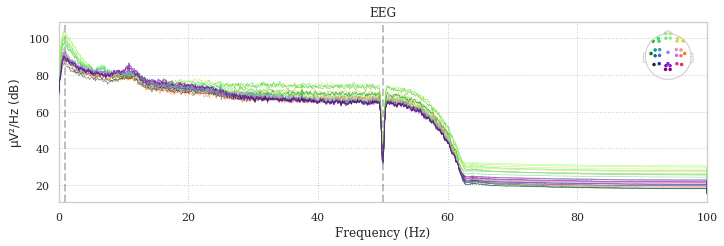

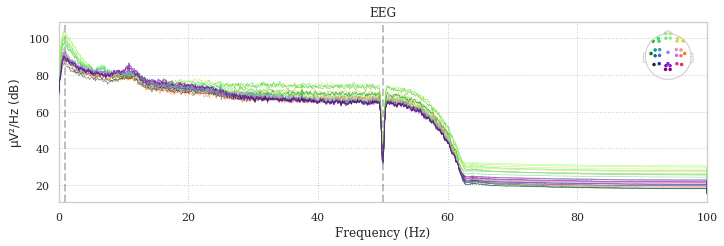

In [ ]:
raw.plot_psd()

## Extract denoised eeg

In [ ]:
# Extract imaginary period (4 seconds)
EOG_ref = 'wICA_with_ref'
ECG_ref = None

ARTIFACT_SUB_FOLDER = f"{EOG_ref}-{ECG_ref}"

train_denoised_eeg = [] 
eval_denoised_eeg =  []

train_denoised_events = []
eval_denoised_events = []

for subID in range(1,21):
    # for sessionID in ['session_0', 'session_1', 'session_2', 'session_3', 'session_4']:
    for sessionID in ['session_0', 'session_2', 'session_4']:

        for runID in ['run_0']:

            selected_raw = dataset[subID][sessionID][runID].copy()
            raw = selected_raw.copy()
            # Change unit from Volt to Micro Volt
            raw._data[:len(selected_eeg_chs), :] = raw._data.copy()[:len(selected_eeg_chs), :] * 1e6
            
            # Notch filter and Bandpass (BCI IV 2b is already applied)
            # Remove power line
            half_sfreq = int(raw.info['sfreq'] / 2)
            raw.notch_filter(freqs=np.arange(50,half_sfreq,50))
            raw.filter(1,50,n_jobs=2,fir_design='firwin') # Shin2017A

            # # 2d Min-Max scaling (-1,1)
            scaled_eeg = scaling_eeg(inputs=raw._data[:len(selected_eeg_chs), :], max_af=1, min_af=-1)
            raw._data[:len(selected_eeg_chs), :] = scaled_eeg

            # Apply Artifact removal technique on RAW
            raw = artifact_removal(raw, EOG_ref=EOG_ref, ECG_ref=ECG_ref)

            # Drop bad channels 
            # Visual checking on evoked and some channels went bad after applying artifact removal techniques

            ch_names = raw.ch_names
            # events = mne.find_events(raw, stim_channel='stim')
            events = mne.find_events(raw, stim_channel='Stim')
            picks = mne.pick_types(raw.info,meg=False,eeg=True,stim=True,eog=True,ecg=False,misc=False)

            # Shin2017A
            # Should subtract with [-5,-2] and then keep only [0,10]
            epochs = mne.Epochs(raw, events, event_id, tmin=-5, tmax=10.0, picks=picks,
                                            baseline=(-5,-2), reject=None, preload=True, 
                                            verbose=False)
            epochs.crop(tmin=0,tmax=10)

            # Apply Artifact removal technique on Epochs
            # epochs = artifact_removal(epochs, EOG_ref=EOG_ref, ECG_ref=ECG_ref)
            
            # # Save data
            # epochs.save(fname=f'Datasets/Shin2017A/{ARTIFACT_SUB_FOLDER}/sub-{subID:02}-{sessionID}-{runID}-eeg-epo.fif',
            #             split_size='2GB',
            #             overwrite=True,
            #             verbose=False)

            # # get numpy data 
            epochs.pick_types(eeg=True)
            epochs.pick_channels(ch_names=selected_eeg_chs)
            np_data = epochs.get_data()[:n_event_ids,:,:selected_data_len] # Shin2017A

            # Extract training data
            # if sessionID in ['session_0', 'session_1', 'session_2']: 
            if sessionID in ['session_0', 'session_2']:  # Shin2017A
                train_denoised_eeg.append(np_data)
                train_denoised_events.append(epochs.events[:n_event_ids])
            # Extract evaluating data
            else:
                eval_denoised_eeg.append(np_data)
                eval_denoised_events.append(epochs.events[:n_event_ids])


             # Check
            print(np_data.shape)
            print(epochs.events.shape)
            print('='*100)

    #         break
    #     break
    # break
    
# List to Numpy
train_denoised_eeg = np.array(train_denoised_eeg)
eval_denoised_eeg = np.array(eval_denoised_eeg)

# Combined epochs
train_denoised_eeg = train_denoised_eeg.reshape(-1, len(selected_eeg_chs), selected_data_len)
eval_denoised_eeg = eval_denoised_eeg.reshape(-1, len(selected_eeg_chs), selected_data_len)

# Reshape list of events
# (Number of events, 3 datas)
# 3 datas = (Timestamp, Offset, Event)
train_denoised_events = np.array(train_denoised_events).reshape(-1,3)
eval_denoised_events = np.array(eval_denoised_events).reshape(-1,3)

# Extract Info for Numpy to EpochArray
eval_denoised_info = epochs.info

(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 2000)
(20, 3)
(20, 30, 20

In [ ]:
print(train_denoised_eeg.shape)
print(eval_denoised_eeg.shape)

print(train_denoised_events.shape)
print(eval_denoised_events.shape)

(800, 30, 2000)
(400, 30, 2000)
(800, 3)
(400, 3)


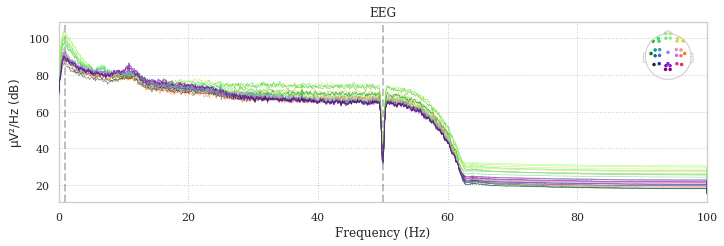

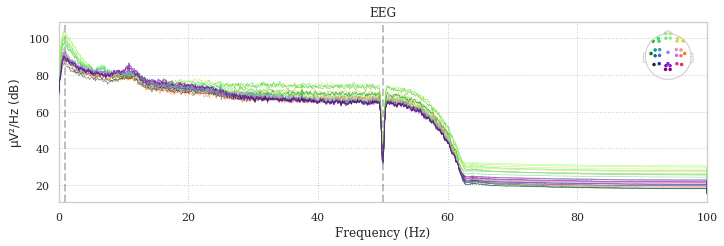

In [ ]:
raw.plot_psd()

In [ ]:
# Events
train_events = train_cont_events.copy()
eval_events = eval_cont_events.copy()

list_epochs_modeling = [train_cont_eeg,
                        train_denoised_eeg,
                        eval_cont_eeg,
                        eval_denoised_eeg]

print(train_events[:,-1].shape)
print(train_events[:,-1][:10])
print(eval_events[:,-1].shape)
print(eval_events[:,-1][:10])
print('-'*100)

for e_type in list_epochs_modeling:
    # print(e_type.get_data().shape)
    print(e_type.shape)
    print(np.max(e_type))
    print(np.min(e_type))
    print('-'*100)

(800,)
[1 2 1 2 1 2 1 2 2 1]
(400,)
[1 2 2 1 2 1 1 2 1 2]
----------------------------------------------------------------------------------------------------
(800, 30, 2000)
1.202533048136978
-0.8887170838330662
----------------------------------------------------------------------------------------------------
(800, 30, 2000)
1.0245007064295357
-0.8574973704989379
----------------------------------------------------------------------------------------------------
(400, 30, 2000)
1.354947501054249
-0.8126986921947988
----------------------------------------------------------------------------------------------------
(400, 30, 2000)
1.1379540890832267
-0.8013437724811157
----------------------------------------------------------------------------------------------------
